# Mask analysis full pipeline for level1

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys, os
#from cellpose import io
from skimage import io
from skimage.measure import label, regionprops
import itertools

other_dir_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..','..'))
sys.path.append(other_dir_path)

import IMCprocess.spatial_analysis.mask_utils as mu
import IMCprocess.utils.utils as ut

## Merge label for level2 in level1 object

In [5]:
data_path = '/Users/pattama/Desktop/UiB/cancer/example_share_code/share_with_vladan/mask_analysis/example_data/'
data_lev1 = ut.read_pickle_obj(data_path+'00hanna_adata_totalNB_obj_Level1.pkl')
Ep_lev2 = ut.read_pickle_obj(data_path+'02hanna_adata_totalNB_obj_EpLevel2.pkl')
Im_lev2 = ut.read_pickle_obj(data_path+'02hanna_adata_totalNB_obj_ImmuneLevel2.pkl')
Fi_lev2 = ut.read_pickle_obj(data_path+'02hanna_adata_totalNB_obj_Level2.pkl')

In [6]:
# get anndata for level1, epithelial level2, immune level2, fibroblast level2
level1_adata = data_lev1.adata_dict['level1']
Ep_adata = Ep_lev2.adata_dict['Ep_level2']
Im_adata = Im_lev2.adata_dict['Immune_level2']
Fi_adata = Fi_lev2.adata_dict['Fibro_level2']

In [7]:
def add_level2_to_level1_obs(level1_adata, level2_adata_list):
    '''
    Add level2 annotation to level1 adata object
    '''
    level1_adata.obs['level2'] = level1_adata.obs['level1_annotated'].astype(str)
    for lev2_adata in level2_adata_list:
        lev2_col = lev2_adata.obs.columns[lev2_adata.obs.columns.str.contains('level2')][0]
        lev2_adata.obs['level2'] = lev2_adata.obs[
            'level1_annotated'].astype('str') + '_' + lev2_adata.obs[lev2_col].astype('str')
        level1_adata.obs.loc[lev2_adata.obs.level2.index, 'level2'] = lev2_adata.obs.level2
    return level1_adata

In [10]:
add_level2_to_level1_obs(level1_adata=level1_adata, level2_adata_list=[Ep_adata, Im_adata, Fi_adata])

AnnData object with n_obs × n_vars = 132951 × 51
    obs: 'img_id', 'PhenoGraph_clusters', 'level1_annotated', 'level2'
    uns: 'pca', 'PhenoGraph_Q', 'PhenoGraph_k', 'neighbors', 'umap', 'PCs', 'dendrogram_PhenoGraph_clusters', 'PhenoGraph_clusters_colors', 'level1_annotated_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [11]:
# Update level1_adata with leve2 label to data_lev1
data_lev1.adata_dict['level1'] = level1_adata

## Create IMG mask object with cell, cancer and tissue mask

In [12]:
def full_pipeline_IMG_mask(labeled_anndata, img_id, 
                    cell_mask_file, 
                    cancer_mask_file, 
                    tissue_mask_file  ):
    # 1. Get only the object for image R2_002
    Img_adata = labeled_anndata[labeled_anndata.obs['img_id'] == img_id]
    # 2. Create mask object for Cell_mask, cancer_mask and tissue_mask
    Cell_mask = mu.Mask(mask_file=cell_mask_file,
                        img_id=img_id, mask_type='cell_mask')
    Cancer_mask = mu.Mask(mask_file=cancer_mask_file,
                          img_id=img_id, mask_type='cancer_mask')
    Tissue_mask = mu.Mask(mask_file=tissue_mask_file,
                          img_id=img_id, mask_type='tissue_mask')
    # 3. Create Img_mask object
    Img_object = mu.Img_mask(Img_adata, Cell_mask, Cancer_mask, Tissue_mask)

    # 4. plot_outline masks and save in the folder 'output/outline_masks'
    if not os.path.exists('output/outline_masks'):
        os.makedirs('output/outline_masks')
        print("output/outline_masks folder created successfully")
    else:
        print("output/outline_masks Folder already exists")

    print("Plotting outline masks for image {}".format(img_id))
    Img_object.plot_outline_mask(masktype='cell_mask', output_file='output/outline_masks/{}_cell_mask.png'.format(img_id))
    Img_object.plot_outline_mask(masktype='cancer', output_file='output/outline_masks/{}_cancer_mask.png'.format(img_id))
    Img_object.plot_outline_mask(masktype='tissue', output_file='output/outline_masks/{}_tissue_mask.png'.format(img_id))

    # 5. plot outline masks with labels and save in the folder 'output/outline_masks'
    mu.plt_outline_label(Cancer_mask.pixels, 
                         Cancer_mask.mask_regprops,
                         Cancer_mask.mask_labeled,
                         output_file='output/outline_masks/{}_cancer_mask_label.png'.format(img_id))
    mu.plt_outline_label(Tissue_mask.pixels, 
                         Tissue_mask.mask_regprops,
                         Tissue_mask.mask_labeled,
                         output_file='output/outline_masks/{}_tissue_mask_label.png'.format(img_id))

    # 6. Get mask info and list cell_i in cancer_mask and tissue_mask and save in the folder 'output/mask_data'
    if not os.path.exists('output/mask_data'):
        os.makedirs('output/mask_data')
        print("output/mask_data folder created successfully")
    else:
        print("output/mask_data Folder already exists")

    print("Plotting outline masks for image {}".format(img_id))
    Img_object.cells_in_cancer_tb.to_csv('output/mask_data/{}_cancer_mask_cells.csv'.format(img_id))
    Img_object.cells_in_tissue_tb.to_csv('output/mask_data/{}_tissue_mask_cells.csv'.format(img_id))

    # 7. create cell data table with cells in cancer, tissue, stroma
    # and save in the folder 'output/mask_data'
    Img_object.cells_data.to_csv('output/mask_data/{}_cells_data.csv'.format(img_id))
    Img_object.cells_list_df.to_csv('output/mask_data/{}_cells_list.csv'.format(img_id))
    # we could save Img_object as pickle object
    #ut.save_pickle_obj('output/mask_data/{}_Img_object.pkl'.format(img_id), Img_object)
    return Img_object.cells_data
    
    
    

R2_001
output/outline_masks Folder already exists
Plotting outline masks for image R2_001


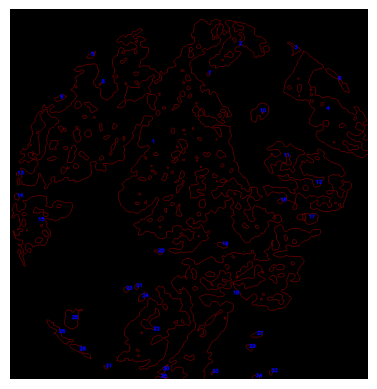

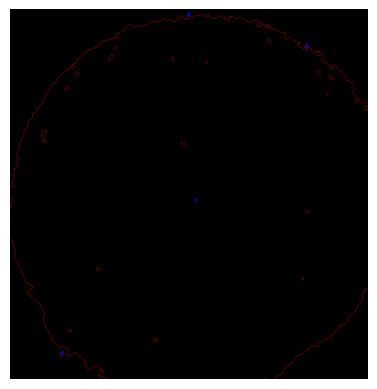

output/mask_data Folder already exists
Plotting outline masks for image R2_001
--------------------------------------------------
R2_002
output/outline_masks Folder already exists
Plotting outline masks for image R2_002


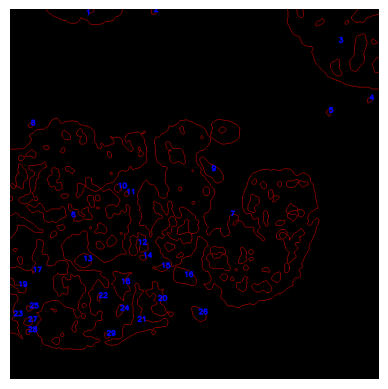

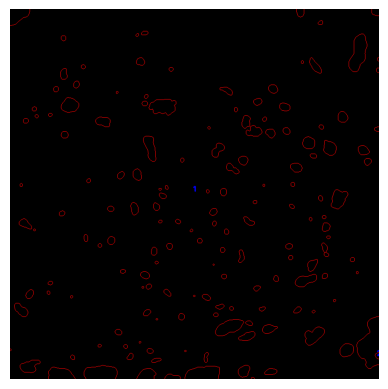

output/mask_data Folder already exists
Plotting outline masks for image R2_002
--------------------------------------------------
R2_003
output/outline_masks Folder already exists
Plotting outline masks for image R2_003


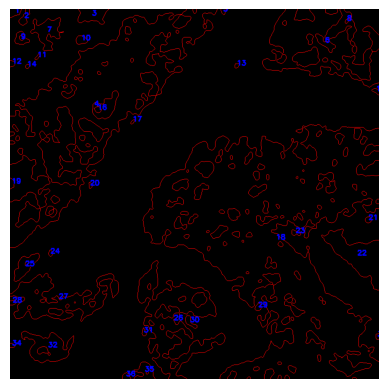

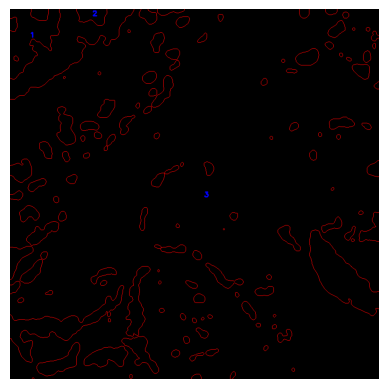

output/mask_data Folder already exists
Plotting outline masks for image R2_003
--------------------------------------------------


In [20]:
# create a list of info for each image: img_id, cell_mask_file, cancer_mask_file, tissue_mask_file
data_input_path = '/Users/pattama/Desktop/UiB/cancer/git_repo/IMCprocess/notebooks/mask_analysis/example_data/'
img_info = [['R2_001',data_input_path+'Patient2_001.tiff',data_input_path+'Patient2_001_cancer_mask.tiff',data_input_path+'Patient2_001_tissue_mask.tiff'],
            ['R2_002',data_input_path+'Patient2_002.tiff',data_input_path+'Patient2_002_cancer_mask.tiff',data_input_path+'Patient2_002_tissue_mask.tiff'],
            ['R2_003',data_input_path+'Patient2_003.tiff',data_input_path+'Patient2_003_cancer_mask.tiff',data_input_path+'Patient2_003_tissue_mask.tiff'],
            ]
input_anndata = data_lev1.adata_dict['level1']
cells_data_list = []
for img_id, cell_mask_file, cancer_mask_file, tissue_mask_file in img_info:
    print(img_id)
    cells_data = full_pipeline_IMG_mask(labeled_anndata = input_anndata, 
                                        img_id=img_id, 
                                        cell_mask_file=cell_mask_file,
                                        cancer_mask_file=cancer_mask_file,
                                        tissue_mask_file=tissue_mask_file)
    cells_data_list.append(cells_data)
    print('--------------------------------------------------')

In [85]:
cells_data_list[0]

,Cell_id,img_id,PhenoGraph_clusters,level1_annotated,level2,location,cell_label
0,14301_3,R2_001,25,Ep,Ep_Ca_nonstem,cancer,1
1,14302_3,R2_001,29,Fibro,Fibro_aSMA+_FAPlow_PDGFRalow_PDGFRblow,cancer,2
2,14303_3,R2_001,14,Fibro,Fibro_aSMA+_PDGFRalow_PDGFRblow,cancer,3
3,14304_3,R2_001,43,Ep,Ep_Ca_nonstem,cancer,4
4,14305_3,R2_001,9,Ep,Ep_Ca_nonstem,cancer,5
...,...,...,...,...,...,...,...
7174,21475_3,R2_001,3,Immune,Immune_CD8,cancer,7175
7175,21476_3,R2_001,2,Ep,Ep_Ca_nonstem,cancer,7176
7176,21477_3,R2_001,15,Ep,Ep_Ca_nonstem,cancer,7177
7177,21478_3,R2_001,41,Undef,Undef,cancer,7178


In [90]:
cells_data_list[0].columns[cells_data_list[0].columns.str.contains('level1')][0]

'level1_annotated'

In [95]:
def get_cell_count_df(cells_data_list,level, img_info):
    img_ids = [img_id[0] for img_id in img_info]
    label = cells_data_list[0].columns[
        cells_data_list[0].columns.str.contains(level)][0]
    cell_count_ls = [pd.DataFrame(
        df[label].value_counts(normalize=True)).rename(
                columns={label:img_id}) 
            for df, img_id in zip(cells_data_list, img_ids)]
    cell_count_df = pd.concat(cell_count_ls, axis=1, sort=True).T
    return cell_count_df

In [96]:
cell_count_df_level2 = get_cell_count_df(cells_data_list, 'level2',img_info)
cell_count_df_level2

,Amb,Ep_Ca_nonstem,Ep_Ca_stem,Fibro_FAP+_PDGFRalow,Fibro_FAP+_PDGFRalow_PDGFRblow,Fibro_FAPlow_PDGFRa+_PDGFRblow,Fibro_FAPlow_PDGFRalow_PDGFRblow,Fibro_Neg,Fibro_PDGFRa+,Fibro_PDGFRalow_PDGFRblow,...,Fibro_aSMAlow_PDGFRalow_PDGFRblow,Immune_CD4,Immune_CD4_FoxP3,Immune_CD4_ki67,Immune_CD8,Immune_CD8_CD4_FoxP3,Immune_CD8_ki67,Immune_Undef,Undef,Ves
R2_001,0.025491,0.480429,0.001950,0.004597,0.011283,0.008915,0.018387,0.007940,0.003204,0.019641,...,0.004040,0.032734,0.027859,0.005850,0.063240,0.015740,0.008079,0.067697,0.096253,0.053768
R2_002,0.029277,0.296919,0.000874,0.001092,0.016605,0.004588,0.020319,0.010050,0.001311,0.021630,...,0.004370,0.105965,0.048066,0.010706,0.114267,0.056806,0.013983,0.082150,0.105309,0.037361
R2_003,0.020740,0.616592,0.008688,0.007848,0.011491,0.001121,0.006726,0.001962,0.000280,0.005605,...,0.001121,0.017937,0.016816,0.005045,0.011491,0.005886,0.001401,0.033632,0.080998,0.049608


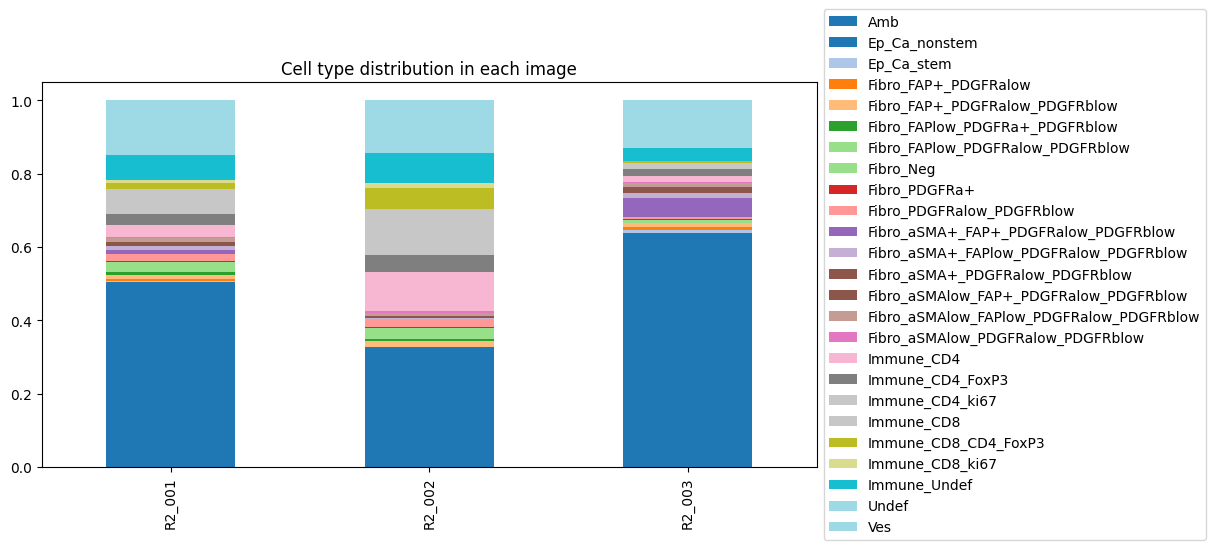

In [97]:
# plot cell type distribution in each image and 
# save in the folder 'output/plot'
ax = cell_count_df_level2.plot(kind='bar', stacked=True,
                        colormap='tab20', 
                        figsize=(10,5), 
                        title='Cell type distribution in each image')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('output/plot/cell_type_distribution_level2.png', bbox_inches='tight')
plt.show()

In [98]:
cell_count_df_level1 = get_cell_count_df(cells_data_list, 'level1',img_info)
cell_count_df_level1

,Amb,Ep,Fibro,Immune,Undef,Ves
R2_001,0.025491,0.482379,0.120908,0.221201,0.096253,0.053768
R2_002,0.029277,0.297793,0.098318,0.431942,0.105309,0.037361
R2_003,0.020740,0.625280,0.131166,0.092209,0.080998,0.049608


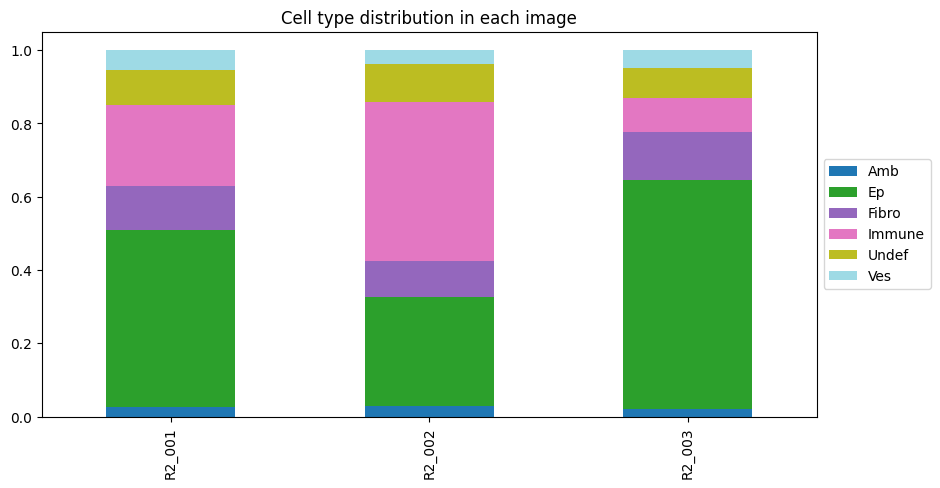

In [99]:
# plot cell type distribution in each image and 
# save in the folder 'output/plot'
ax = cell_count_df_level1.plot(kind='bar', stacked=True,
                        colormap='tab20', 
                        figsize=(10,5), 
                        title='Cell type distribution in each image')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('output/plot/cell_type_distribution_level1.png', bbox_inches='tight')
plt.show()